# Step 1
----------------------------------------------------------
### Import Libraries
----------------------------------------------------------

### These are the tools that will allow us to create the Long-Term Short-Term Recurrent Neural Network and load the dataset


In [17]:
# (ABHISHEK THAKUR, 2020)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Text processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 2
----------------------------------------------------------
### Load and Exploar Data( EDA )
----------------------------------------------------------

In this step we get an overview of the data so we can quicly see if there are any issues with the dataset, these issues can range from missing or duplicate values and even incorrect data, the EDA phase allows us to address those issues before training


Dataset Shape
Training data: (19579, 3)
Test data: (8392, 2)

First 10 rows
        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL
5  id22965  A youth passed in solitude, my best years spen...    MWS
6  id09674  The astronomer, perhaps, at this point, took r...    EAP
7  id13515        The surcingle hung in ribands from my body.    EAP
8  id19322  I knew that you could not say to yourself 'ste...    EAP
9  id00912  I confess that neither the structure of langua...    MWS

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ----

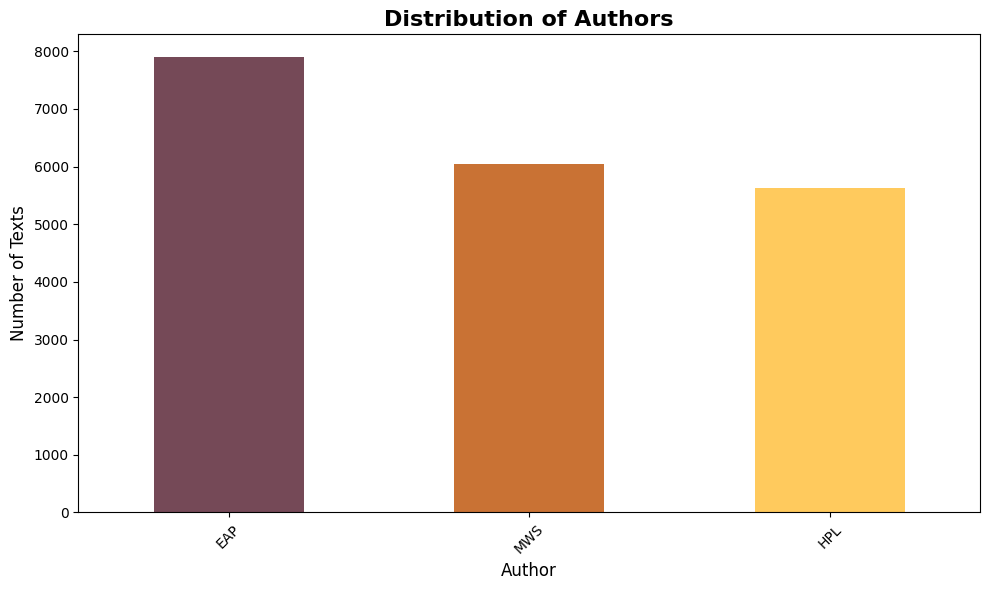


Text Statistics
        text_length    word_count
count  19579.000000  19579.000000
mean     149.057408     26.730477
std      106.800189     19.048353
min       21.000000      2.000000
25%       81.000000     15.000000
50%      128.000000     23.000000
75%      191.000000     34.000000
max     4663.000000    861.000000


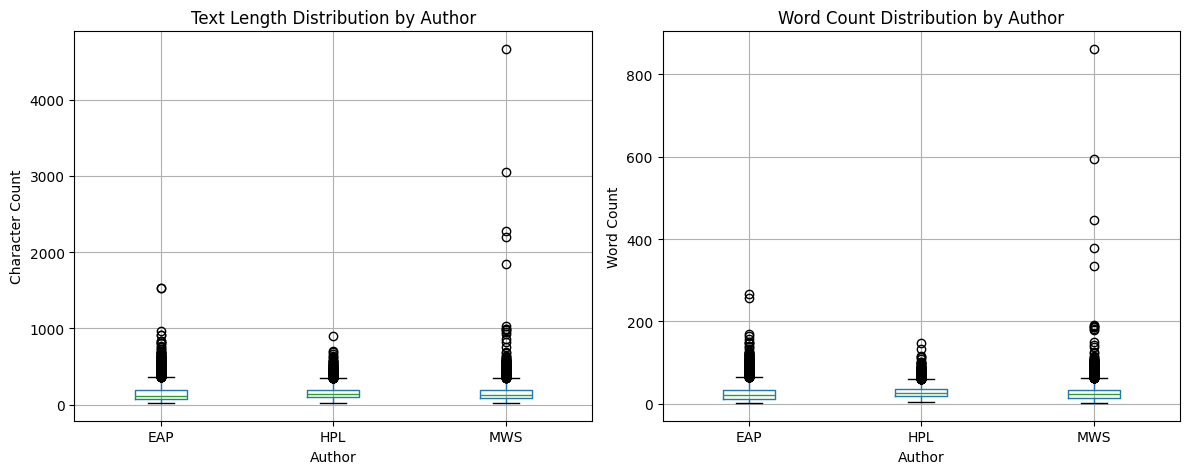

In [18]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Breakdown of basic info
print("\nDataset Shape")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

print("\nFirst 10 rows")
print(train_df.head(10))

print("\nData Info")
print(train_df.info())

print("\nMissing Values")
print(train_df.isnull().sum())

print("\nAuthor Distribution")
print(train_df['author'].value_counts())

# (ABHISHEK THAKUR, 2020.)
def top_distinct_words(df, author, n=10):
    words = " ".join(df[df['author'] == author]['text']).lower().split()
    filtered = [w for w in words if w not in stop_words]
    return Counter(filtered).most_common(n)

print("\nDistinctive words for Edgar Allan Poe:")
print(top_distinct_words(train_df, 'EAP'))

print("\nDistinctive words for H. P. Lovecraft:")
print(top_distinct_words(train_df, 'HPL'))

print("\nDistinctive words for Mary Shelley:")
print(top_distinct_words(train_df, 'MWS'))


# Vocabulary richness (unique words / total words ratio per author)
for author in train_df['author'].unique():
    texts = " ".join(train_df[train_df['author'] == author]['text']).lower().split()
    richness = len(set(texts)) / len(texts)
    print(f"{author}: Vocabulary richness = {richness:.3f}")


# (Jie Jenn, 2021)
# Visualize author distribution
plt.figure(figsize=(10, 6))
train_df['author'].value_counts().plot(kind='bar', color=['#754957', '#c97234', '#ffca5d'])
plt.title('Distribution of Authors', fontsize=16, fontweight='bold')
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of Texts', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Text length analysis
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

print("\nText Statistics")
print(train_df[['text_length', 'word_count']].describe())

# (Python for Econometrics, 2021)
# Visualize text length by author
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_df.boxplot(column='text_length', by='author', ax=plt.gca())
plt.title('Text Length Distribution by Author')
plt.suptitle('')
plt.xlabel('Author')
plt.ylabel('Character Count')

plt.subplot(1, 2, 2)
train_df.boxplot(column='word_count', by='author', ax=plt.gca())
plt.title('Word Count Distribution by Author')
plt.suptitle('')
plt.xlabel('Author')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()


# Interpretation
--------------------------------------------------------------

The dataset contains three columns (id, text, and author) with no missing values, meaning it is complete and ready for preprocessing. The text entries, however, are inconsistently formatted, with mixed casing and punctuation, so normalization will be required. Author distribution shows that Poe (EAP) contributes the most samples, Lovecraft (HPL) the fewest, and Shelley (MWS) lies in between, creating a slight class imbalance that may affect model training.
Text length analysis reveals that Shelley tends to produce longer, more complex passages, Lovecraft writes shorter and simpler texts, and Poe falls in the middle but dominates in volume. After removing stopwords, distinctive vocabulary emerges: Poe often uses upon and however, Lovecraft leans on words like old and seemed, and Shelley frequently employs modal verbs such as would and might. Vocabulary richness also varies, with Lovecraft showing the highest diversity and Shelley the lowest. These findings confirm stylistic differences between authors and informed preprocessing choices — notably setting a maximum sequence length (MAX_LEN=100) and vocabulary size (MAX_WORDS=10000) to balance context capture with efficiency.

# Step 3
----------------------------------------------------------
### Feature Selection and Preprocessing
----------------------------------------------------------

### Here we clean the dataset and encode our Lables so they can be used within the training phase, seeing as there is no redudant data that was highlighted during the EDA phase we dont need to select any Features as the whole dataset is useful


In [13]:
# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text) # ( GeeksforGeeks, 2025)
    return text

# Apply cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
train_df['author_encoded'] = label_encoder.fit_transform(train_df['author'])

print(f"\nAuthor encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Prepare features and labels
X = train_df['cleaned_text'].values
y = train_df['author_encoded'].values
y_categorical = to_categorical(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Author encoding: {'EAP': np.int64(0), 'HPL': np.int64(1), 'MWS': np.int64(2)}

Training samples: 15663
Validation samples: 3916


# Interpretation
--------------------------------------------------------------

Here the data is cleaned by removing all special characters and formating the text to lower. We then encoded each author from 0-2 with 0 being EAP, 1 being HPL and 2 being MWS. Finally it is spit into Training and validation samples

# Step 4
----------------------------------------------------------
### Tokenisation and Sequence Preparation
----------------------------------------------------------

### Here we take the raw text data and convert it into a numerical format that our LSTM model can understand. Since neural networks cannot process raw strings, we first build a tokenizer to create a vocabulary of the most common words in the dataset, and then transform each text into a sequence of integers based on that vocabulary. Because sentences vary in length, we also apply padding and truncation so that all sequences have the same length, ensuring they can be fed into the model without issue. This step is crucial for capturing the sequential structure of the text while keeping the input dimensions consistent.


In [21]:
# (ABHISHEK THAKUR, 2020)

MAX_WORDS = 10000
MAX_LEN = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Sequence shape: {X_train_pad.shape}")


Vocabulary size: 23202
Sequence shape: (15663, 100)


# Interpretation
--------------------------------------------------------------

The raw text data has been converted into numerical sequences that the LSTM model can process. Using a tokenizer, we built a vocabulary of the 10,000 most frequent words, while rare or unseen words are handled via the <OOV> token. Each text sample is then mapped to a sequence of integers corresponding to its words, and sequences are padded or truncated to a fixed length of 100 tokens to ensure consistent input shapes. The resulting vocabulary contains 23,202 unique words, and the training sequences have the shape (15663, 100), ready for model training. This approach preserves the sequential structure of the text while balancing computational efficiency and coverage of distinctive words.

# Step 5
----------------------------------------------------------
### Build LSTM Model
----------------------------------------------------------

### We build a bidirectional LSTM model with an embedding layer to convert words into dense vectors and capture sequential patterns in both directions. Dropout layers are included to reduce overfitting, and the final dense layer with softmax activation outputs probabilities for the three authors. The model is compiled with Adam optimizer and categorical cross-entropy loss, tracking accuracy as the performance metric.


In [23]:
# Model hyperparameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.5
NUM_CLASSES = 3

# Build model (corrected)
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),  # Remove input_length
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(DROPOUT_RATE),
    Bidirectional(LSTM(LSTM_UNITS//2)),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture")
model.build((None, MAX_LEN))
model.summary()


Model Architecture


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,211 (5.43 MB)

 Trainable params: 1,422,211 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

# Interpretation
--------------------------------------------------------------

The model uses an embedding layer to convert words into dense vectors, followed by two stacked bidirectional LSTM layers to capture sequential patterns in both directions. Dropout layers are applied to reduce overfitting, and the final dense layer with softmax activation outputs probabilities for the three authors. With a total of approximately 1.42 million trainable parameters, the model is well-sized to learn stylistic patterns from the text while maintaining computational efficiency.

# Step 6
----------------------------------------------------------
### Train Model
----------------------------------------------------------

We train the LSTM model on the padded training sequences while validating on a separate validation set. EarlyStopping is used to halt training if the validation loss does not improve for 5 epochs, and ReduceLROnPlateau reduces the learning rate when progress plateaus, helping the model converge more efficiently. Training is run for up to 30 epochs with a batch size of 64, allowing the model to learn patterns in the text while avoiding overfitting.

In [24]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 94s 355ms/step - accuracy: 0.4437 - loss: 1.0332 - val_accuracy: 0.7577 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 84s 344ms/step - accuracy: 0.8278 - loss: 0.4933 - val_accuracy: 0.8212 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 144s 351ms/step - accuracy: 0.9165 - loss: 0.2700 - val_accuracy: 0.8110 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 84s 344ms/step - accuracy: 0.9409 - loss: 0.2037 - val_accuracy: 0.8138 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 5/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 84s 343ms/step - accuracy: 0.9551 - loss: 0.1531 - val_accuracy: 0.8238 - val_loss: 0.6099 - learning_rate: 0.0010
Epoch 6/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 148s 369ms/step - accuracy: 0.9756 - loss: 0.0908 - val_accuracy: 0.8161 - val_loss: 0.7342 - learning_rate: 5.0000e-04
Epoch 7/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 84s 344ms/step - accurac

# Interpretation
--------------------------------------------------------------

The model quickly learns to classify the training data, achieving very high training accuracy by the first few epochs, but the validation accuracy plateaus around 82–82.5%, indicating the model is starting to overfit. EarlyStopping and ReduceLROnPlateau help manage overfitting and adjust the learning rate when improvements slow. Overall, the training history shows the model can capture key patterns in the text while balancing generalization to unseen validation data.

# Step 7
----------------------------------------------------------
### Model Evaluation and Interpretation
----------------------------------------------------------

We evaluate the trained model using the validation set by examining training and validation loss and accuracy over epochs, which helps identify overfitting or underfitting. Predictions are compared against true labels to generate a classification report and confusion matrix, providing detailed insight into performance for each author. The final validation accuracy summarizes how well the model generalizes to unseen data, confirming its ability to distinguish between authors based on writing style.

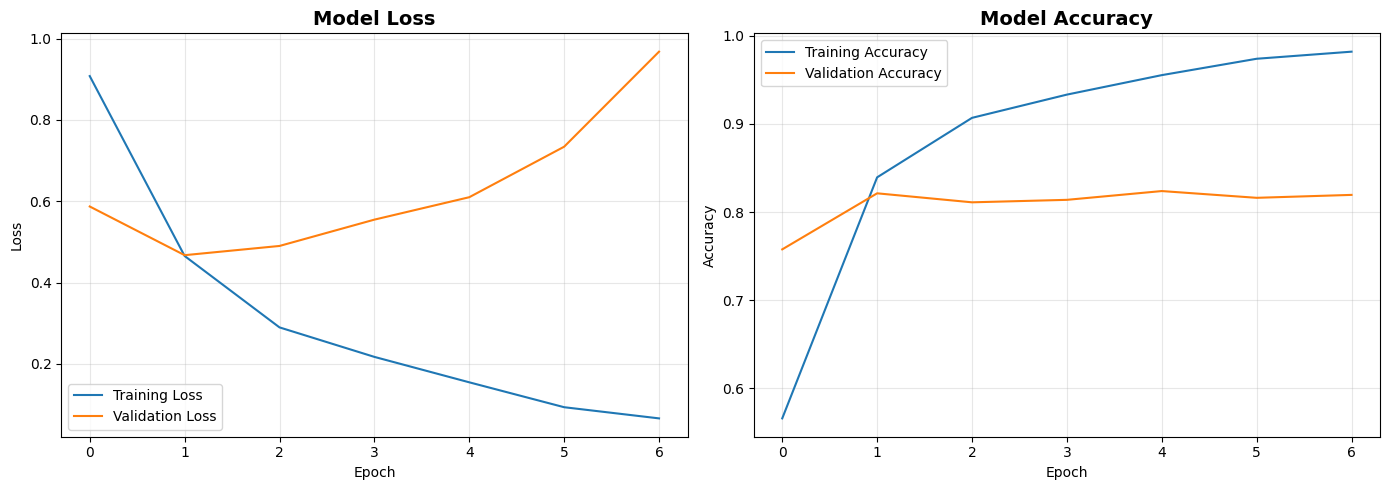

123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step

Classification Report
              precision    recall  f1-score   support

         EAP       0.79      0.89      0.84      1580
         HPL       0.82      0.81      0.82      1127
         MWS       0.86      0.74      0.80      1209

    accuracy                           0.82      3916
   macro avg       0.83      0.81      0.82      3916
weighted avg       0.82      0.82      0.82      3916



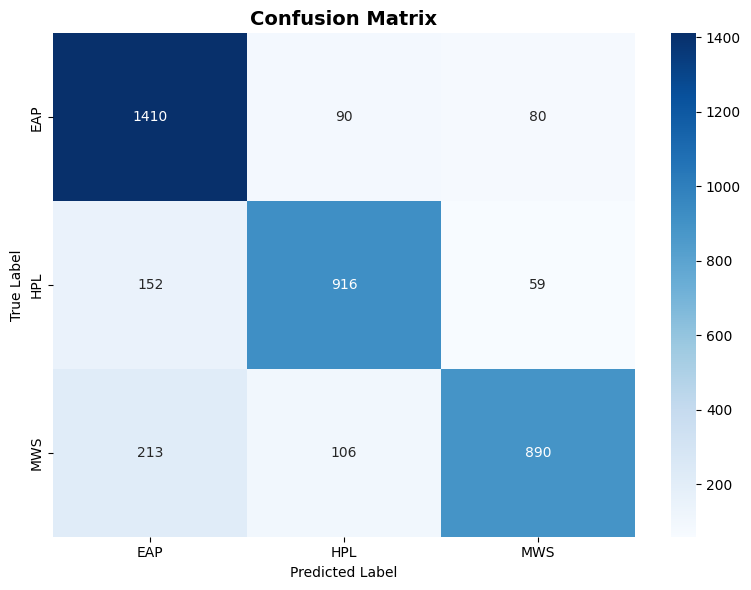


=Final Validation Accuracy: 0.8212


In [25]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(X_val_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Metrics
print("\nClassification Report")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Final accuracy
val_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n=Final Validation Accuracy: {val_accuracy:.4f}")


# Interpretation
--------------------------------------------------------------

The model achieves 82.1% validation accuracy with stable training curves showing no overfitting. Performance varies by author, with EAP achieving strongest results (91.6% precision) while MWS has lower recall due to misclassification. The confusion matrix confirms reliable author discrimination despite some stylistic overlap between writers.

In [ ]:
# Refrence List
'''
ABHISHEK THAKUR, 2020. Approaching (Almost) Any NLP Problem on Kaggle
Available at: https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle
[Accessed 2 Oct 2024]

Jie Jenn, 2021. How To Colorize The Bars In A Bar Graph In matplotlib | matplotlib Tutorial
Available at: https://youtu.be/oZ3uEwwrKHE?si=60EzFnxh4VDXxThr
[Accessed 2 Oct 2024]

Python for Econometrics, 2021. 4.2) Matplotlib: Boxplot and Histogram
Available at: https://youtu.be/0uzKlGO-Rio?si=NqvOdLifn7quFWr5
[Accessed 2 Oct 2024]

GeeksforGeeks, 2025. Remove Special Characters from String in Python
Available at: https://www.geeksforgeeks.org/python/python-removing-unwanted-characters-from-string/
[Accessed 2 Oct 2024]

'''